In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.units as u

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'

In [2]:
df = pd.read_csv('1to13.cpa_flare_out.csv')
nf = len(df)
nt = len(np.unique(df['file']))
print(str(nf) + ' flare detections from ' + str(nt) + ' lightcurves')
mask = (df['f_chisq'] < df['g_chisq']) & (df['f_chisq'] > 0) & (df['ed'] > 0) & (df['f_chisq'] < 10)
df = df#[mask]
nf = len(df)
nt = len(np.unique(df['file']))
print(str(nf) + ' flare detections from ' + str(nt) + ' lightcurves')

7729 flare detections from 2363 lightcurves
7729 flare detections from 2363 lightcurves


In [3]:
df_param = pd.read_csv('1to13.cpa_param_out.csv')

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


(1, 100000000.0)

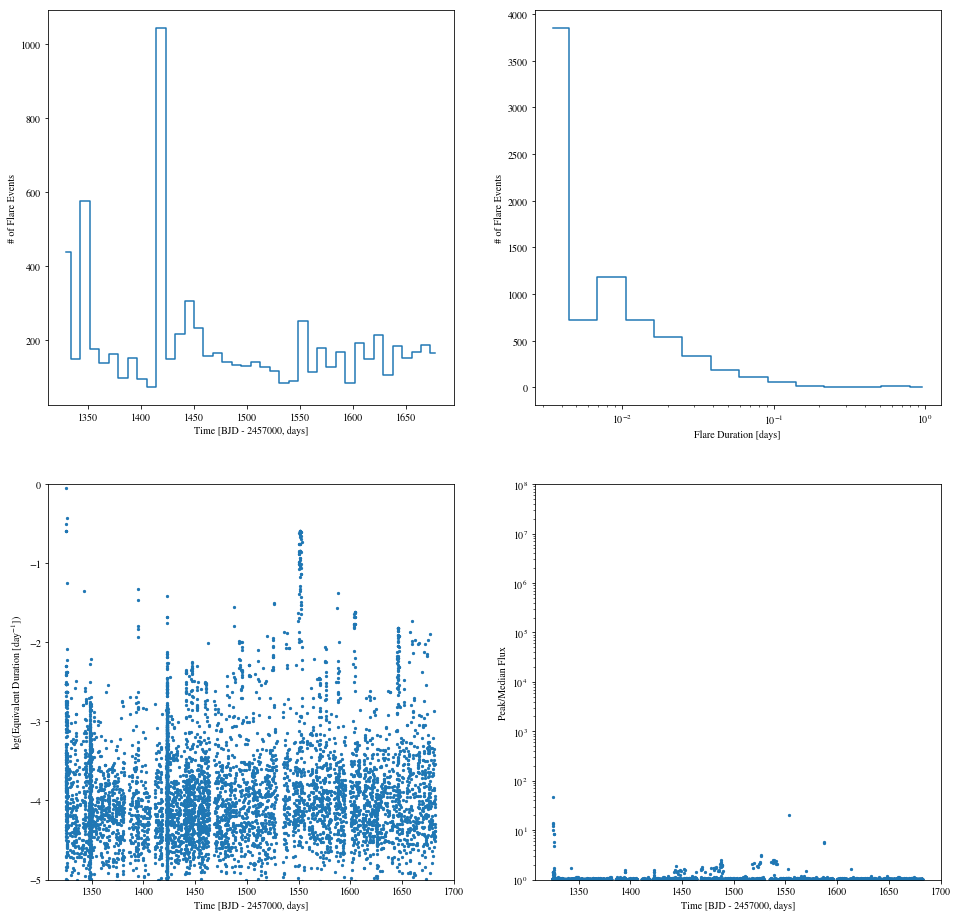

In [4]:
fig, axes = plt.subplots(figsize=(16,16), nrows=2, ncols=2)

hist, bins = np.histogram(df['t0'], bins=40)
bins = 0.5*(bins[1:] + bins[:-1])
axes[0][0].plot(bins, hist, linestyle='steps-mid')
axes[0][0].set_xlabel('Time [BJD - 2457000, days]')
axes[0][0].set_ylabel('# of Flare Events')

duration = df['t1'] - df['t0']
bins = np.logspace(np.log10(np.min(duration)), np.log10(np.max(duration)), num=15)
hist, bins = np.histogram(duration, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
axes[0][1].semilogx(bins, hist, linestyle='steps-mid')
axes[0][1].set_xlabel('Flare Duration [days]')
axes[0][1].set_ylabel('# of Flare Events')

bins = 0.5*(bins[1:] + bins[:-1])
y = np.log10(df['ed'])
yerr = 0.434*df['ed_err']/df['ed']
axes[1][0].scatter(df['t0'], y, s=5)
#axes[1][0].set_yscale('log')
axes[1][0].set_ylim(-5, 0)
axes[1][0].set_xlabel('Time [BJD - 2457000, days]')
axes[1][0].set_ylabel(r'log(Equivalent Duration [day$^{-1}$])')

bins = 0.5*(bins[1:] + bins[:-1])
axes[1][1].scatter(df['t0'], df['peak']/df['med'], s=5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Time [BJD - 2457000, days]')
axes[1][1].set_ylabel('Peak/Median Flux')
axes[1][1].set_ylim(1, 1e8)

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


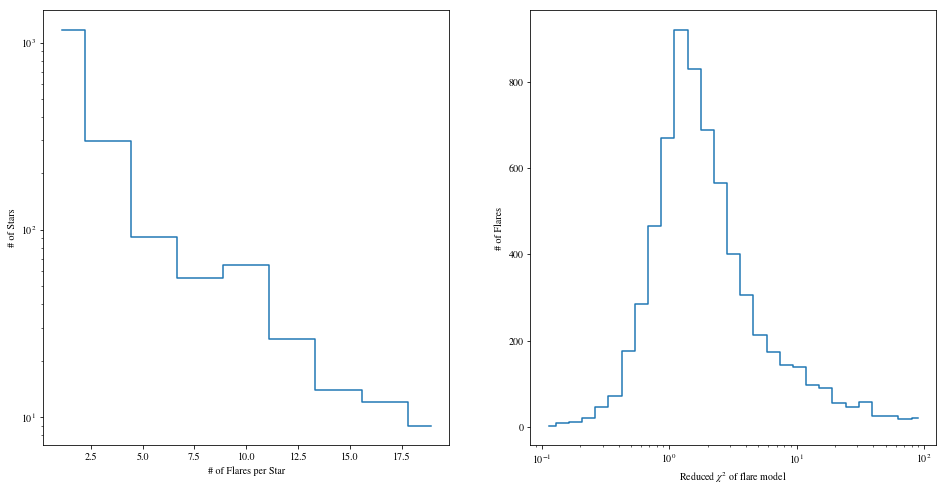

In [5]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

unique_tic = df['TIC'].drop_duplicates().as_matrix()
num_flares = np.zeros(len(unique_tic))
for idx, val in enumerate(unique_tic):
    num_flares[idx] = len(df[df['TIC'] == val])

bins = np.linspace(0, 20, num=10)
hist, bins = np.histogram(num_flares, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
axes[0].plot(bins, hist, linestyle='steps-mid')
axes[0].set_xlabel('# of Flares per Star')
axes[0].set_ylabel('# of Stars')
axes[0].set_yscale('log')

q = df['f_chisq']
bins = np.logspace(-1, 2, num=30)
hist, bins = np.histogram(q, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
axes[1].plot(bins, hist, linestyle='steps-mid')
axes[1].set_xlabel(r'Reduced $\chi^{2}$ of flare model')
axes[1].set_ylabel('# of Flares')
axes[1].set_xscale('log')

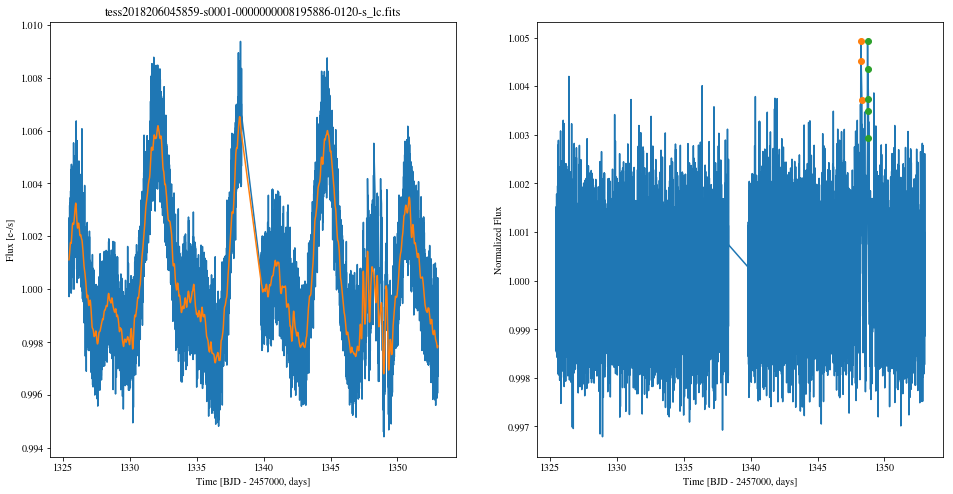

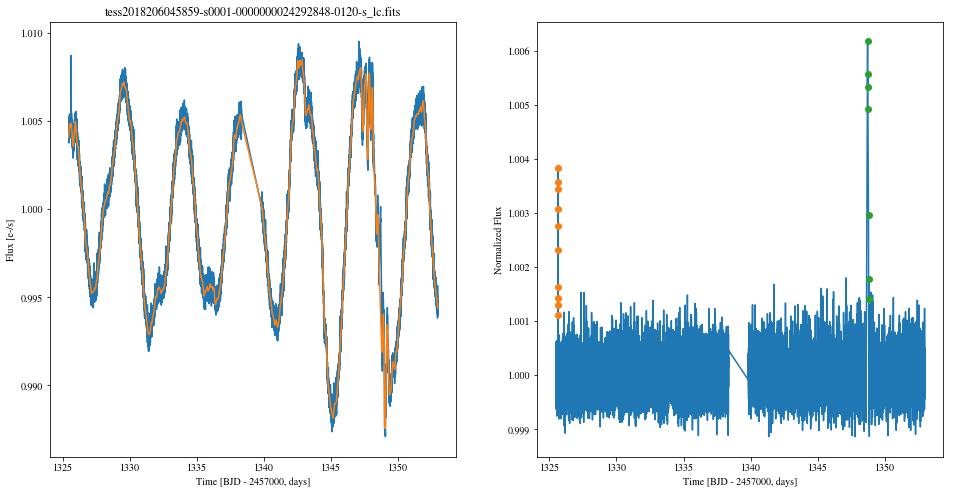

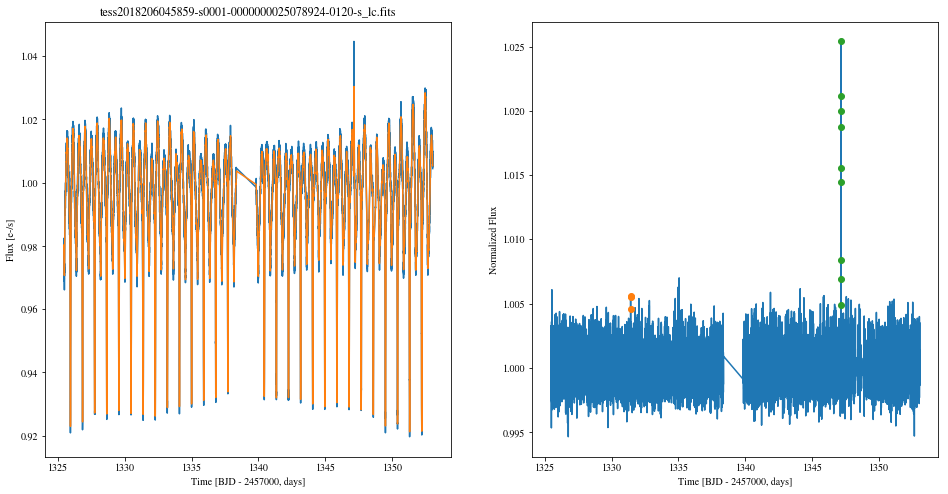

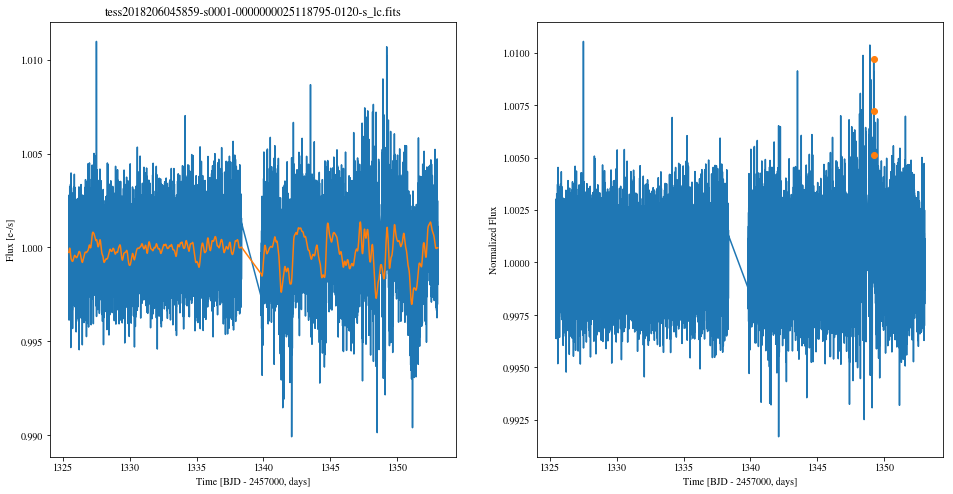

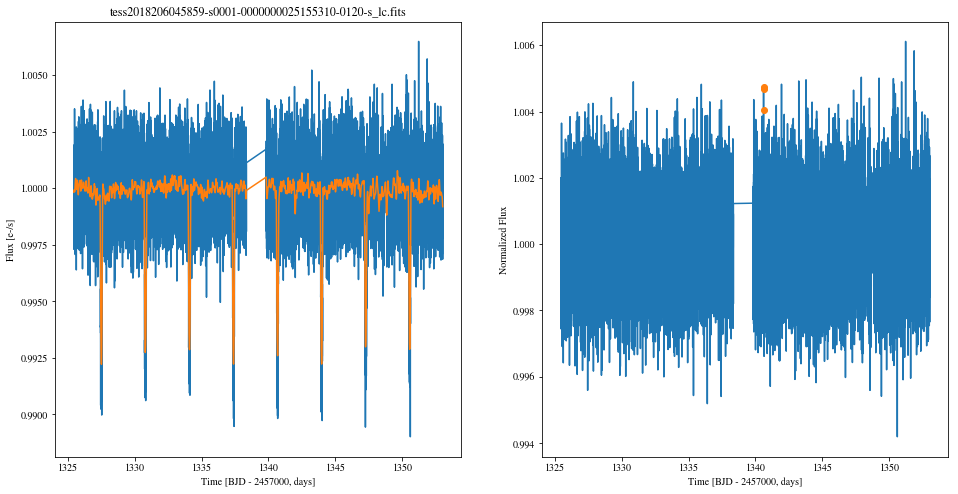

In [6]:
from flareTools import id_segments

for filename in np.unique(df['file'].values)[0:5]:
    tstart = df[df['file'] == filename]['t0'].values
    tstop = df[df['file'] == filename]['t1'].values
    
    fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
    
    with fits.open(path+filename, mode='readonly') as hdulist:
        tess_bjd = hdulist[1].data['TIME']
        pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality = hdulist[1].data['QUALITY']
        
    smo = np.loadtxt(path+filename+'.gp')
    ok_cut = (quality == 0) & (~np.isnan(tess_bjd)) & (~np.isnan(pdcsap_flux)) & (~np.isnan(pdcsap_flux_error))
    
    dt_limit = 12/24 # 12 hours
    trim = 4/24 # 4 hours
    istart, istop = id_segments(tess_bjd[ok_cut], dt_limit, dt_trim=trim)

    time_c = np.array([])
    flux_c = np.array([])
    error_c = np.array([])

    for seg_idx in range(len(istart)):
        tess_bjd_seg = tess_bjd[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_seg = pdcsap_flux[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_error_seg = pdcsap_flux_error[ok_cut][istart[seg_idx]:istop[seg_idx]]

        time_c = np.concatenate((time_c, tess_bjd_seg), axis=0)
        flux_c = np.concatenate((flux_c, pdcsap_flux_seg), axis=0)
        error_c = np.concatenate((error_c, pdcsap_flux_error_seg), axis=0)
        
    median = np.nanmedian(flux_c)
    
    axes[0].plot(time_c, flux_c/median)
    axes[0].plot(time_c, smo)
    axes[0].set_xlabel('Time [BJD - 2457000, days]')
    axes[0].set_ylabel('Flux [e-/s]')
    axes[0].set_title(filename)
    
    x = time_c
    y = flux_c/median - smo + 1
    axes[1].plot(x, y)
    for idx in range(len((tstart))):
        indices = np.where((x >= tstart[idx]) & (x <= tstop[idx]))[0]
        axes[1].plot(x[indices], y[indices], 'o')
    axes[1].set_xlabel('Time [BJD - 2457000, days]')
    axes[1].set_ylabel('Normalized Flux')

In [7]:
len(np.unique(df['file'].values))

2363

In [8]:
# Stuff to manually mask out:

# Sector 1 - noise from 1347 to 1350
# Sector 1 - noise from 1325.3 to 1325.8
# Transits and eclipses (tess2018234235059-s0002-0000000230982885-0121-s_lc.fits is a good example)
# Sector 4 - noise from 1423 to 1423.6
# Tips of periodic variations (tess2018292075959-s0004-0000000007586485-0124-s_lc.fits is a good ex)
# Sector 12 -noise from 1624.8 to 1626.5

# This is covering up a lot of actual flares, I dont know if I want to do this
# The abnormal jumps in the lightcurves dont appear for every LC in a sector
# Maybe the 1% signal mask takes care of a lot of these issues

In [9]:
t0, t1 = df['t0'], df['t1']
mask1 = ~((t0 > 1347) & (t0 < 1350)) & ~((t1 > 1347) & (t1 < 1350))
mask2 = ~((t0 > 1325.3) & (t0 < 1325.8)) & ~((t1 > 1325.3) & (t1 < 1325.8))
mask3 = ~((t0 > 1423) & (t0 < 1423.6)) & ~((t1 > 1423) & (t1 < 1423.6))
mask4 = ~((t0 > 1624.8) & (t0 < 1626.5)) & ~((t1 > 1624.8) & (t1 < 1626.5))
mask = mask1 & mask2 & mask3 & mask4

In [10]:
len(df), len(np.unique(df['file'].values))

(7729, 2363)

In [11]:
len(df), len(np.unique(df['file'].values))

(7729, 2363)

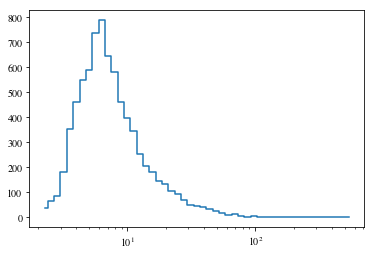

In [12]:
q = df['smo_pk']/df['smo_sig']
bins = np.logspace(np.log10(np.min(q)), np.log10(np.max(q)))
hist, bins = np.histogram(q, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')

In [13]:
# Only allow flare detections above a certain S/N
mask_signal = df['f_chisq'] > 0#df['smo_pk']/df['smo_sig'] > 3
len(df[mask_signal]), len(np.unique(df[mask_signal]['file'].values))

(7080, 2311)

In [ ]:
from flareTools import id_segments

for filename in np.unique(np.unique(df[mask_signal]['file'].values)):
    tstart = df[df['file'] == filename]['t0'].values
    tstop = df[df['file'] == filename]['t1'].values
    
    gauss_fit = False
    entry = df[df['file'] == filename]
    if entry.iloc[0]['g_chisq'] < df.iloc[0]['f_chisq']:
        gauss_fit = True
    
    fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
    
    with fits.open(path+filename, mode='readonly') as hdulist:
        tess_bjd = hdulist[1].data['TIME']
        pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality = hdulist[1].data['QUALITY']
        
    smo = np.loadtxt(path+filename+'.gp')
    ok_cut = (quality == 0) & (~np.isnan(tess_bjd)) & (~np.isnan(pdcsap_flux)) & (~np.isnan(pdcsap_flux_error))
    
    dt_limit = 12/24 # 12 hours
    trim = 4/24 # 4 hours
    istart, istop = id_segments(tess_bjd[ok_cut], dt_limit, dt_trim=trim)

    time_c = np.array([])
    flux_c = np.array([])
    error_c = np.array([])

    for seg_idx in range(len(istart)):
        tess_bjd_seg = tess_bjd[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_seg = pdcsap_flux[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_error_seg = pdcsap_flux_error[ok_cut][istart[seg_idx]:istop[seg_idx]]

        time_c = np.concatenate((time_c, tess_bjd_seg), axis=0)
        flux_c = np.concatenate((flux_c, pdcsap_flux_seg), axis=0)
        error_c = np.concatenate((error_c, pdcsap_flux_error_seg), axis=0)
        
    median = np.nanmedian(flux_c)
    
    axes[0].plot(time_c, flux_c/median)
    axes[0].plot(time_c, smo)
    axes[0].set_xlabel('Time [BJD - 2457000, days]')
    axes[0].set_ylabel('Flux [e-/s]')
    axes[0].set_title(filename)
    
    x = time_c
    y = flux_c/median - smo + 1
    axes[1].plot(x, y)
    for idx in range(len((tstart))):
        indices = np.where((x >= tstart[idx]) & (x <= tstop[idx]))[0]
        marker = 'o'
        if gauss_fit:
            marker = 'x'
        axes[1].plot(x[indices], y[indices], marker)
    axes[1].set_xlabel('Time [BJD - 2457000, days]')
    axes[1].set_ylabel('Normalized Flux')
    plt.savefig('/astro/store/gradscratch/tmp/scw7/tessData/plots/'+filename+'.png')
    plt.close()

In [15]:
# Measure flare energies
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
print(len(tic_gaia_table), len(df[mask_signal]))
dfg = pd.merge(tic_gaia_table, df[mask_signal], on='TIC', how='right')
len(dfg)

128258 7080


7080

In [16]:
ed = (dfg['ed'].values*u.day).to(u.s)
energy = (ed*dfg['lum']*u.erg/u.s).value
dfg['energy'] = energy

Text(0, 0.5, 'Number of Flares')

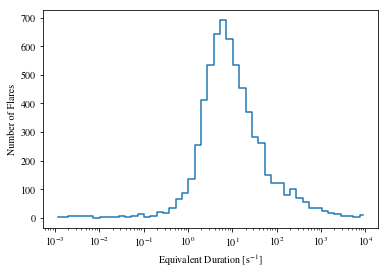

In [31]:
bins = np.logspace(-3, 4)
hist, bins = np.histogram(ed[np.isfinite(ed)], bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')
plt.xlabel(r'Equivalent Duration [s$^{-1}$]')
plt.ylabel('Number of Flares')

Text(0, 0.5, 'Number of Flares')

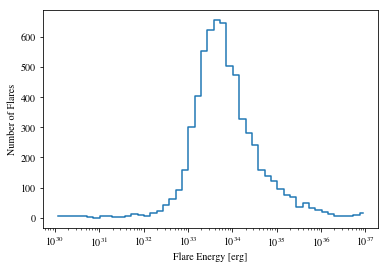

In [17]:
bins = np.logspace(30, 37)
hist, bins = np.histogram(energy[np.isfinite(energy)], bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')
plt.xlabel('Flare Energy [erg]')
plt.ylabel('Number of Flares')

In [18]:
dfg_dup = dfg.drop_duplicates('TIC')
num_flares = np.empty(len(dfg_dup))
for idx in range(len(dfg_dup)):
    num_flares[idx] = len(dfg[dfg['TIC'] == dfg_dup.iloc[idx]['TIC']])

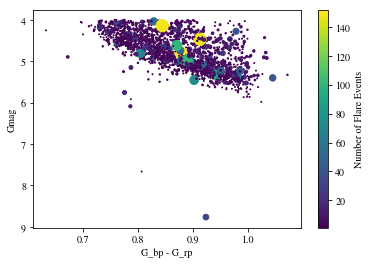

In [19]:
distance = dfg_dup['r_est']
M_G = dfg_dup['G_mag'] - 5*np.log10(dfg_dup['r_est']) + 5
plt.scatter(dfg_dup['G_BPbrmag'] - dfg_dup['G_RPmag'], M_G, s=num_flares, c=num_flares)
plt.gca().invert_yaxis()
plt.xlabel('G_bp - G_rp')
plt.ylabel('Gmag')
plt.colorbar(label='Number of Flare Events')

In [20]:
# Superflares only (>10^34 erg)
supercut = dfg['energy'] > 1e34
dfg_s = dfg[supercut]
dfg_dup_s = dfg_s.drop_duplicates('TIC')
num_flares_s = np.empty(len(dfg_dup_s))
for idx in range(len(dfg_dup_s)):
    num_flares_s[idx] = len(dfg_s[dfg_s['TIC'] == dfg_dup_s.iloc[idx]['TIC']])
len(dfg_s), len(dfg_dup_s)

(2217, 737)

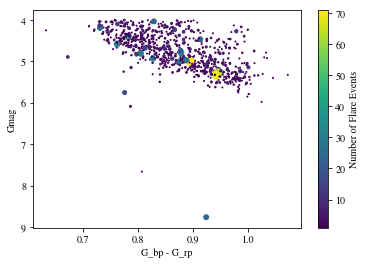

In [21]:
distance = dfg_dup_s['r_est']
M_G = dfg_dup_s['G_mag'] - 5*np.log10(dfg_dup_s['r_est']) + 5
plt.scatter(dfg_dup_s['G_BPbrmag'] - dfg_dup_s['G_RPmag'], M_G, s=num_flares_s, c=num_flares_s)
plt.gca().invert_yaxis()
plt.xlabel('G_bp - G_rp')
plt.ylabel('Gmag')
plt.colorbar(label='Number of Flare Events')

In [87]:
# Plot LCs for superflares
for filename in np.unique(np.unique(dfg_s['file'].values)):
    tstart = dfg_s[dfg_s['file'] == filename]['t0'].values
    tstop = dfg_s[dfg_s['file'] == filename]['t1'].values
    
    gauss_fit = False
    entry = dfg_s[dfg_s['file'] == filename]
    if entry.iloc[0]['g_chisq'] < dfg_s.iloc[0]['f_chisq']:
        gauss_fit = True
    
    fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
    
    with fits.open(path+filename, mode='readonly') as hdulist:
        tess_bjd = hdulist[1].data['TIME']
        pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality = hdulist[1].data['QUALITY']
        
    smo = np.loadtxt(path+filename+'.gp')
    ok_cut = (quality == 0) & (~np.isnan(tess_bjd)) & (~np.isnan(pdcsap_flux)) & (~np.isnan(pdcsap_flux_error))
    
    dt_limit = 12/24 # 12 hours
    trim = 4/24 # 4 hours
    istart, istop = id_segments(tess_bjd[ok_cut], dt_limit, dt_trim=trim)

    time_c = np.array([])
    flux_c = np.array([])
    error_c = np.array([])

    for seg_idx in range(len(istart)):
        tess_bjd_seg = tess_bjd[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_seg = pdcsap_flux[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_error_seg = pdcsap_flux_error[ok_cut][istart[seg_idx]:istop[seg_idx]]

        time_c = np.concatenate((time_c, tess_bjd_seg), axis=0)
        flux_c = np.concatenate((flux_c, pdcsap_flux_seg), axis=0)
        error_c = np.concatenate((error_c, pdcsap_flux_error_seg), axis=0)
        
    median = np.nanmedian(flux_c)
    
    axes[0].plot(time_c, flux_c/median)
    axes[0].plot(time_c, smo)
    axes[0].set_xlabel('Time [BJD - 2457000, days]')
    axes[0].set_ylabel('Flux [e-/s]')
    axes[0].set_title(filename)
    
    x = time_c
    y = flux_c/median - smo + 1
    axes[1].plot(x, y)
    for idx in range(len((tstart))):
        indices = np.where((x >= tstart[idx]) & (x <= tstop[idx]))[0]
        marker = 'o'
        if gauss_fit:
            marker = 'x'
        axes[1].plot(x[indices], y[indices], marker)
    axes[1].set_xlabel('Time [BJD - 2457000, days]')
    axes[1].set_ylabel('Normalized Flux')
    plt.savefig('/astro/store/gradscratch/tmp/scw7/tessData/plots/'+filename+'.png')
    plt.close()

In [22]:
a = dfg_s[dfg_s['file'] == 'tess2018206045859-s0001-0000000025170114-0120-s_lc.fits']

In [36]:
(a['ed'].values*u.d).to(u.s)

<Quantity [15.8195051 , 17.84795395] s>

In [37]:
a['energy'].values

array([1.65522064e+34, 1.86746056e+34])